# Longstaff Schwartz


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng

from sklearn.linear_model import Ridge
from numpy.polynomial.polynomial import Polynomial

In [ ]:
# parametres
r = 0.1
sigma = 0.25
x_0 = 100
K = 110
N = 10
T = 1

In [ ]:
# payoff
def phi(k, x):
  return np.exp(-r * k/N)*np.maximum(K - x, 0)

In [ ]:
seed = 0
rng = default_rng(seed)
rng.standard_normal(20)

n_sample = 50

In [ ]:
def generate_samples(n_samples, random_generator):
  S = np.zeros((n_samples, N))
  dW = random_generator.standard_normal((n_samples, N))
  S[:,0] = x_0
  for i in range(1, N):
    S[:,i] = S[:,i-1] + S[:,i-1]*r*(T/N) + (T/N)**(1/2) * sigma * S[:, i-1]*dW[:,i - 1]
  return S

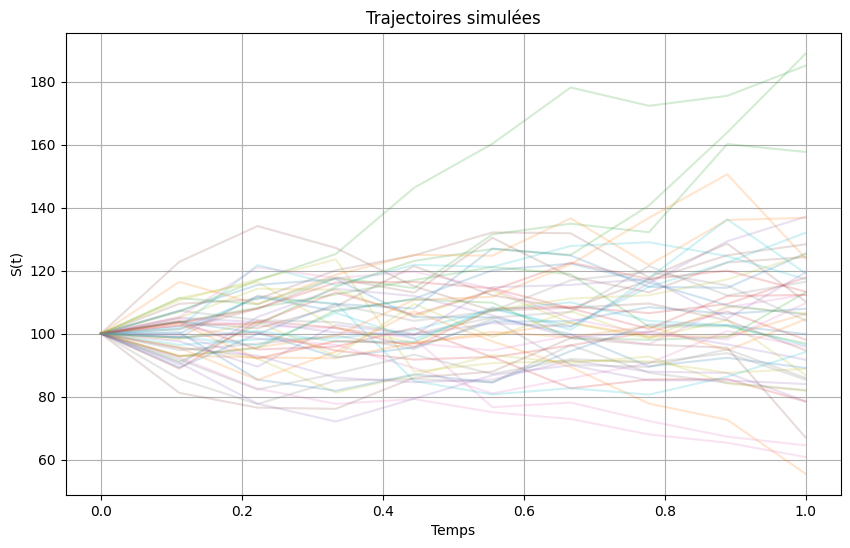

In [ ]:
# test
S = generate_samples(n_sample, rng)
plt.figure(figsize=(10, 6))
for i in range(S.shape[0]):
    plt.plot(np.linspace(0, T, N), S[i], label=f'Trajectoire {i+1}', alpha = 0.2)
plt.title('Trajectoires simulées')
plt.xlabel('Temps')
plt.ylabel('S(t)')
plt.grid(True)
plt.show()

In [ ]:
X = np.zeros(S.shape)
for k in range(N):
  X[:,k] = phi(k, S[:,k])

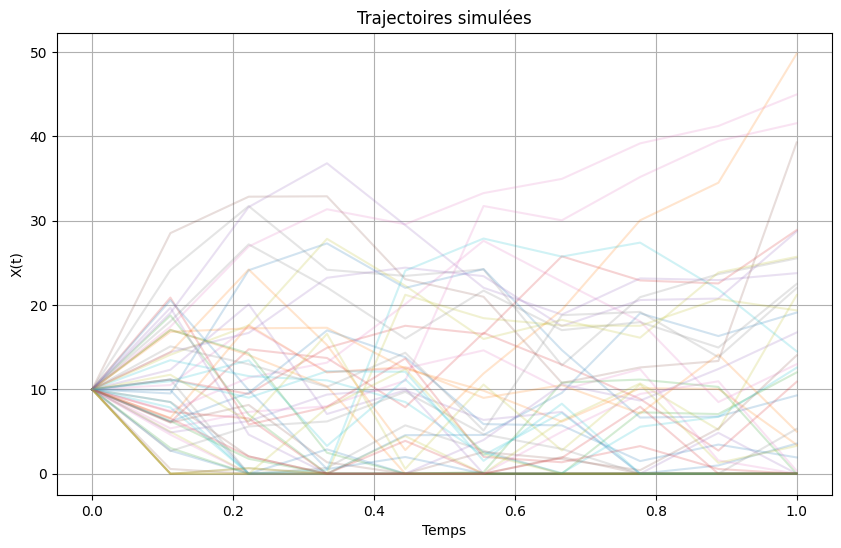

In [ ]:
# test
plt.figure(figsize=(10, 6))
for i in range(S.shape[0]):
    plt.plot(np.linspace(0, T, N), X[i], label=f'Trajectoire {i+1}', alpha = 0.2)
plt.title('Trajectoires simulées')
plt.xlabel('Temps')
plt.ylabel('X(t)')
plt.grid(True)
plt.show()

In [ ]:
# algorithme de longstaff_schwartz
C = np.zeros(n_sample)
C = X[:,N-1]
dt = T/N

for i in range(N-2, -1, -1):
  X_poly = np.vstack([S[:, i]**j for j in range(3)]).T
  model = Ridge(alpha=0.1, fit_intercept=False)
  model.fit(X_poly, C)

  contval = model.predict(X_poly)

  ind = X[:, i] > contval
  C[ind] = X[ind, i]

print(C.mean())

12.342874241549056


In [ ]:
def american_put(M, base, plot_ = False, print_ = True, rng = rng):
  """
  Estime le prix d'un put américain

  Paramètres :
  M : int
    Nombre de simulations du prix du sous-jacent.
  base : list de fonctions
    Fonctions de base pour approximer la valeur de continuation.
  plot_ : bool, optionnel (par défaut = False)
    Affiche les graphes des valeurs intrinsèque et de continuation si True.
  print_ : bool, optionnel (par défaut = True)
    Affiche le prix estimé si True.
  rng : générateur aléatoire, optionnel
    Générateur pour la simulation.

  Retourne :
     - Prix estimé du put américain (float)
     - Erreur type de l'estimation (float)
  """

  S = generate_samples(M, rng)
  X = np.zeros(S.shape)

  for k in range(N):
    X[:,k] = phi(k, S[:,k])

  C = np.zeros(M)
  C = X[:,N-1]
  dt = T/N

  for i in range(N-2, -1, -1):
    X_poly = np.vstack([base[j](S[:, i]) for j in range(len(base))]).T
    model = Ridge(alpha=0.01, fit_intercept=False)
    model.fit(X_poly, C)

    if plot_:
      x = np.linspace(x_0 * 0.6, x_0 * 1.4, 100)
      X_poly_x = np.vstack([base[j](x) for j in range(len(base))]).T
      contval_x = model.predict(X_poly_x)
      intrinsic_val = phi(i, x)

      plt.figure(figsize=(8, 5))

      plt.plot(x, intrinsic_val, label="Valeur intrinsèque", color='blue', linewidth=2)
      plt.plot(x, contval_x, label="Valeur de continuation estimée", color='red', linestyle='dashed', linewidth=2)

      plt.xlabel("Prix du sous-jacent")
      plt.ylabel("Valeur")
      plt.legend()
      plt.title(f"Valeur de continuation vs. Valeur intrinsèque (étape {i})")
      plt.show()

    contval = model.predict(X_poly)

    ind = X[:, i] > contval
    C[ind] = X[ind, i]
  if print_:
    print("Prix du put americain : " + str(C.mean()))
  return C.mean(), C.std()/M**(1/2)

def put(M, print_ = True, rng = rng):
  S = generate_samples(M, rng)
  payoff = phi(N, S[:,-1])
  if print_:
    print("Prix du put : " + str(payoff.mean()))
  return payoff.mean(), payoff.std()/M**(1/2)

american_put(10**5, [lambda x: np.ones_like(x)])
american_put(10**5, [lambda x: np.ones_like(x), lambda x: x])
american_put(10**5, [lambda x: np.ones_like(x), lambda x: x, lambda x: np.power(x, 2)], )
p = put(10**5)

Prix du put americain : 11.684413056571474
Prix du put americain : 11.407799600990238
Prix du put americain : 11.640458612056316
Prix du put : 9.642210202044112
